## Let's Do it.

Am not describing the problem here in case you need it, take a look of this thread and you will be sorted for good. http://zindi.africa/competitions/xente-fraud-detection-challenge

### Packages
Packages help you get stuff done as easily and quickly as possible, instead of you writing the background code someone has already done that for you. what is next is you learning how to use it. 

Personally i was a big culprit of writing (library(name_of_package) for even morethan 50 different packages but i learnt to use apply functions to take care and avoid repetition 

In [1]:
# list of packages to use
packages <- c("readr","ggplot2","sqldf","data.table","dplyr","CatEncoders","Hmisc","party","SDMTools",
              "dummies","corrplot","caret","ROCR","randomForest","xgboost")

# readr - reading the csv data
# ggplot2 - hero of visualizations
# sqldf - Manipulate R Data Frames Using SQL
# dplyr - natural/straight way to manipulate data frames
# data.table -  faster aggregation of large datasets
# caret - polished machine learning package in r
# ROCR - plotting ROC curve
# randomForest, xgboost, lightgbm - ml packages

In [2]:
# personally i dont like warnings, turn them off
options(warn=-1)
options(scipen=999)

In [4]:
# checking and loading the packages
to_be_installed <- packages[!packages %in% installed.packages()[,1]] 
# Installing missing packages
if(length(to_be_installed)>0){
  install.packages(to_be_installed)
}
# Loading all the packages
# This where most people put library()
invisible(lapply(packages,library,character.only=TRUE))

### Loading the data

In [6]:
# Lets take it simple and reading one by one
training <- read.csv('data/training.csv',header = T, stringsAsFactors = F)
test <- read.csv('data/test.csv',header = T, stringsAsFactors = F)
sample_submission <- read.csv('data/sample_submission.csv',header = T, stringsAsFactors = F)

In [7]:
# descriptive statistics for the train and test set 

print(summary(training))
print(summary(test))

 TransactionId        BatchId           AccountId         SubscriptionId    
 Length:95662       Length:95662       Length:95662       Length:95662      
 Class :character   Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character   Mode  :character  
                                                                            
                                                                            
                                                                            
  CustomerId        CurrencyCode        CountryCode   ProviderId       
 Length:95662       Length:95662       Min.   :256   Length:95662      
 Class :character   Class :character   1st Qu.:256   Class :character  
 Mode  :character   Mode  :character   Median :256   Mode  :character  
                                       Mean   :256                     
                                       3rd Qu.:256                     
                             

### Focusing on the training data now


In [8]:
glimpse(training)

Observations: 95,662
Variables: 16
$ TransactionId        <chr> "TransactionId_76871", "TransactionId_73770", "T…
$ BatchId              <chr> "BatchId_36123", "BatchId_15642", "BatchId_53941…
$ AccountId            <chr> "AccountId_3957", "AccountId_4841", "AccountId_4…
$ SubscriptionId       <chr> "SubscriptionId_887", "SubscriptionId_3829", "Su…
$ CustomerId           <chr> "CustomerId_4406", "CustomerId_4406", "CustomerI…
$ CurrencyCode         <chr> "UGX", "UGX", "UGX", "UGX", "UGX", "UGX", "UGX",…
$ CountryCode          <int> 256, 256, 256, 256, 256, 256, 256, 256, 256, 256…
$ ProviderId           <chr> "ProviderId_6", "ProviderId_4", "ProviderId_6", …
$ ProductId            <chr> "ProductId_10", "ProductId_6", "ProductId_1", "P…
$ ProductCategory      <chr> "airtime", "financial_services", "airtime", "uti…
$ ChannelId            <chr> "ChannelId_3", "ChannelId_2", "ChannelId_3", "Ch…
$ Amount               <dbl> 1000, -20, 500, 20000, -644, 2000, 10000, -500, …
$ Value          

In [9]:
sum(is.na(training))

[1] 0

Personally i would love to see the money value of the fraudelent transactions

In [10]:
#Creating Dataframe for Amount and Class
trn_amount <- training$Amount
trn_class <- training$FraudResult
trn_class_trn_amount = data.frame(trn_class, trn_amount)

In [11]:
#Valuing the transaction
trans_not_fraud <- c(sqldf("SELECT count(*) as total_not_fraud 
FROM trn_class_trn_amount WHERE trn_class  == 0"))
trans_fraud <- c(sqldf("SELECT count(*) as total_fraud 
FROM trn_class_trn_amount WHERE trn_class  == 1"))
trans_df = data.frame(trans_not_fraud, trans_fraud)

In [12]:
# transposing to have a nice look

tr_trans_df <- transpose(trans_df)
colnames(tr_trans_df) <- rownames(trans_df)
rownames(tr_trans_df) <- colnames(trans_df)
colnames(tr_trans_df) <- c("total")  
print(tr_trans_df)

                total
total_not_fraud 95469
total_fraud       193


Surely the data is imbalanced as an expectation for fraud datasets always

In [13]:
# lets check how good this thieves were
total_thief_harvest = sqldf("SELECT SUM(trn_amount) as total_value_by_thieves 
FROM trn_class_trn_amount
WHERE trn_class == 1")
print(total_thief_harvest)

  total_value_by_thieves
1              296307571


##### Sure this a problem, if this money was lost its really a big issue for the company. personally there is no correlation between competition prize and the money value the intervention if successfully developed could bring to xente. 

In [14]:
# Lets try to have a break down of this

# Lets first Check for the max value of fraud

max_fraud_amount = sqldf("SELECT MAX(trn_amount) as max_value_fraud 
FROM trn_class_trn_amount WHERE trn_class == 1")
print(max_fraud_amount)

  max_value_fraud
1         9880000


##### Nearly 10M, these are not petty thieves

In [15]:
# Lets be fair opposite of max = min

min_fraud_amount = sqldf("SELECT MIN(trn_amount) as min_value_fraud 
FROM trn_class_trn_amount WHERE trn_class == 1")
print(min_fraud_amount)

  min_value_fraud
1         -900000


##### Average for fraud

In [16]:
# Checking for average fraud value

avg_fraud_amount = sqldf("SELECT AVG(trn_amount) as average_fraud 
FROM trn_class_trn_amount WHERE trn_class == 1")
print(avg_fraud_amount)

  average_fraud
1       1535272


##### Out of courosity lets check are this fraudsters 

In [17]:
fraudsters <- training %>% select(CustomerId,FraudResult) %>% filter(FraudResult == 1)%>%group_by(CustomerId) %>% 
     mutate(Total = n()) %>% unique() %>% arrange(desc(Total))
fraudsters

CustomerId,FraudResult,Total
CustomerId_909,1,31
CustomerId_4878,1,22
CustomerId_1988,1,14
CustomerId_4453,1,12
CustomerId_2303,1,8
CustomerId_5054,1,7
CustomerId_2266,1,7
CustomerId_3075,1,7
CustomerId_5155,1,7
CustomerId_3768,1,6


In [18]:
fraudsters %>% nrow()

[1] 54

#### Exploratory Data Analysis

In [19]:
options(repr.matrix.max.cols= 100)
head(training)

TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult
TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,UGX,256,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000,1000,2018-11-15T02:18:49Z,2,0
TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20,20,2018-11-15T02:19:08Z,2,0
TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,UGX,256,ProviderId_6,ProductId_1,airtime,ChannelId_3,500,500,2018-11-15T02:44:21Z,2,0
TransactionId_380,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,UGX,256,ProviderId_1,ProductId_21,utility_bill,ChannelId_3,20000,21800,2018-11-15T03:32:55Z,2,0
TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-644,644,2018-11-15T03:34:21Z,2,0
TransactionId_23223,BatchId_25954,AccountId_1078,SubscriptionId_4238,CustomerId_1432,UGX,256,ProviderId_6,ProductId_3,airtime,ChannelId_3,2000,2000,2018-11-15T03:35:10Z,2,0


In [20]:
# Checking whether there is any missing value in any of the columns
colSums(sapply(training, is.na))

TransactionId              BatchId            AccountId 
                   0                    0                    0 
      SubscriptionId           CustomerId         CurrencyCode 
                   0                    0                    0 
         CountryCode           ProviderId            ProductId 
                   0                    0                    0 
     ProductCategory            ChannelId               Amount 
                   0                    0                    0 
               Value TransactionStartTime      PricingStrategy 
                   0                    0                    0 
         FraudResult 
                   0

In [26]:
library(repr)

# Change plot size to 4 x 3
options(repr.plot.width=8, repr.plot.height=3)

#### lets look at trends

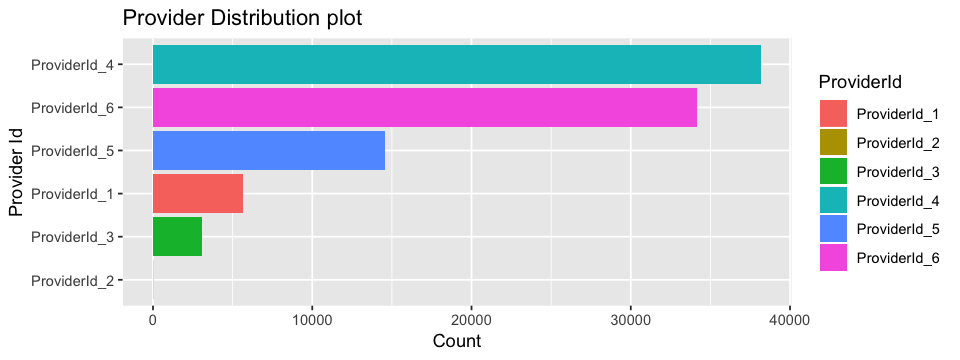

In [27]:
training %>% group_by(ProviderId) %>% count() %>% 

  ggplot() + geom_bar(aes(reorder(ProviderId,n),n,fill=ProviderId), stat = 'identity') + coord_flip() +
 xlab('Provider Id') + ylab('Count') +

  ggtitle('Provider Distribution plot')

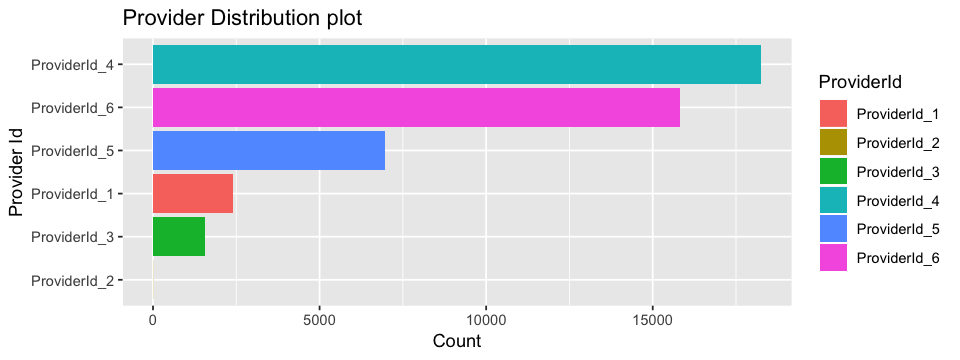

In [28]:
test %>% group_by(ProviderId) %>% count() %>% 

  ggplot() + geom_bar(aes(reorder(ProviderId,n),n,fill=ProviderId), stat = 'identity') + coord_flip() +
 xlab('Provider Id') + ylab('Count') +

  ggtitle('Provider Distribution plot')

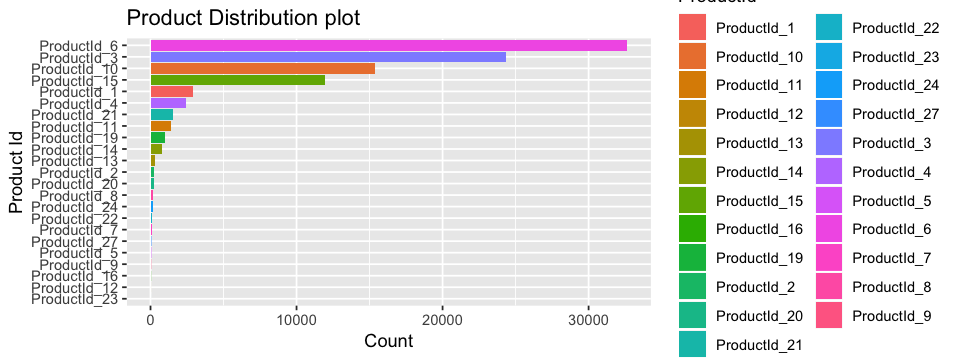

In [29]:
training %>% group_by(ProductId) %>% count() %>% 

  ggplot() + geom_bar(aes(reorder(ProductId,n),n,fill=ProductId), stat = 'identity') + coord_flip() +
 xlab('Product Id') + ylab('Count') +

  ggtitle('Product Distribution plot')

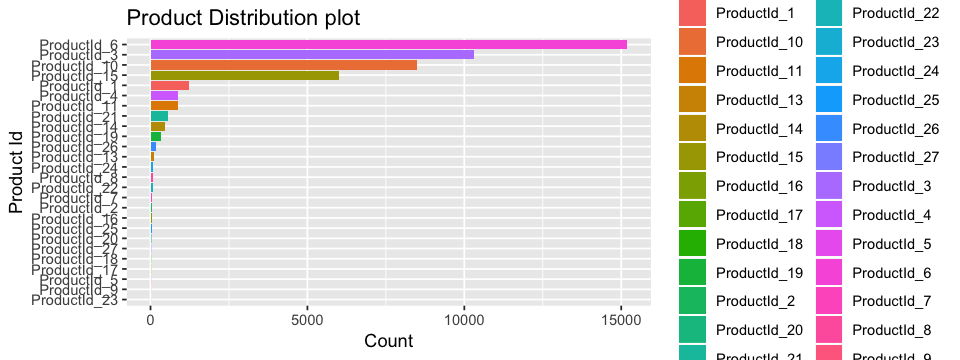

In [30]:
test %>% group_by(ProductId) %>% count() %>% 

  ggplot() + geom_bar(aes(reorder(ProductId,n),n,fill=ProductId), stat = 'identity') + coord_flip() +
 xlab('Product Id') + ylab('Count') +

  ggtitle('Product Distribution plot')

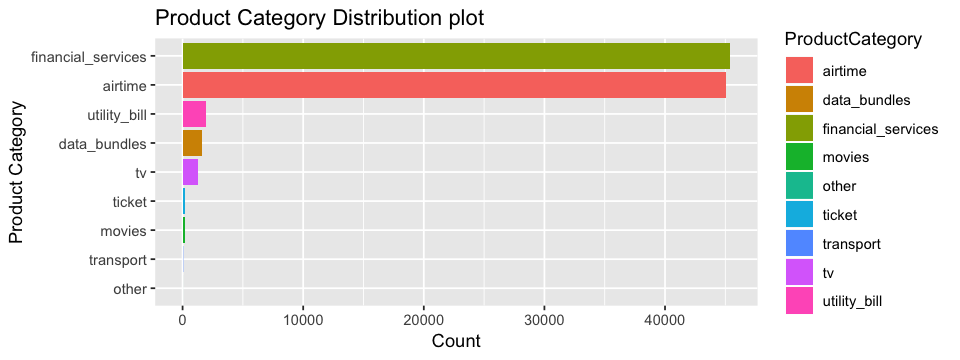

In [31]:
training %>% group_by(ProductCategory) %>% count() %>% 

  ggplot() + geom_bar(aes(reorder(ProductCategory,n),n,fill=ProductCategory), stat = 'identity') + coord_flip() +
 xlab('Product Category') + ylab('Count') +

  ggtitle('Product Category Distribution plot')

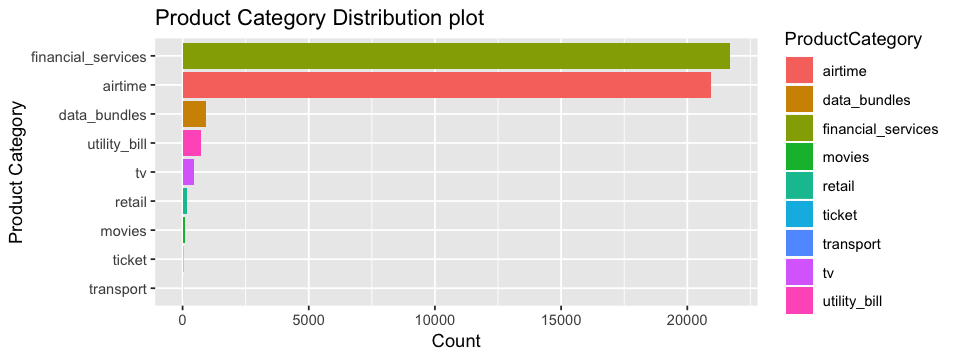

In [32]:
test %>% group_by(ProductCategory) %>% count() %>% 

  ggplot() + geom_bar(aes(reorder(ProductCategory,n),n,fill=ProductCategory), stat = 'identity') + coord_flip() +
 xlab('Product Category') + ylab('Count') +

  ggtitle('Product Category Distribution plot')

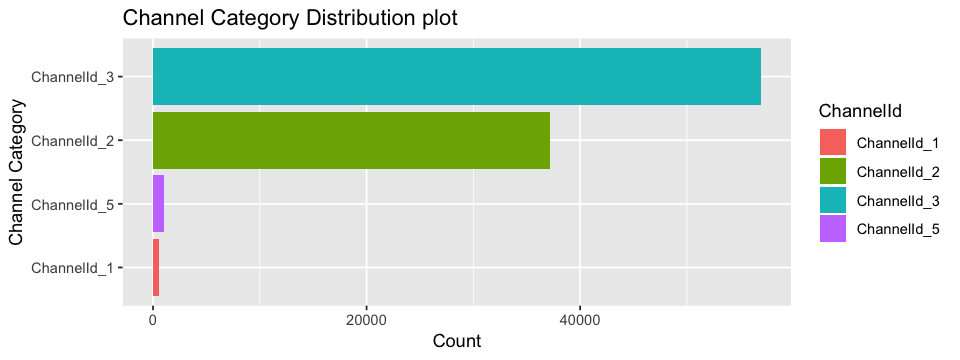

In [33]:
training %>% group_by(ChannelId) %>% count() %>% 

  ggplot() + geom_bar(aes(reorder(ChannelId,n),n,fill=ChannelId), stat = 'identity') + coord_flip() +
 xlab('Channel Category') + ylab('Count') +

  ggtitle('Channel Category Distribution plot')

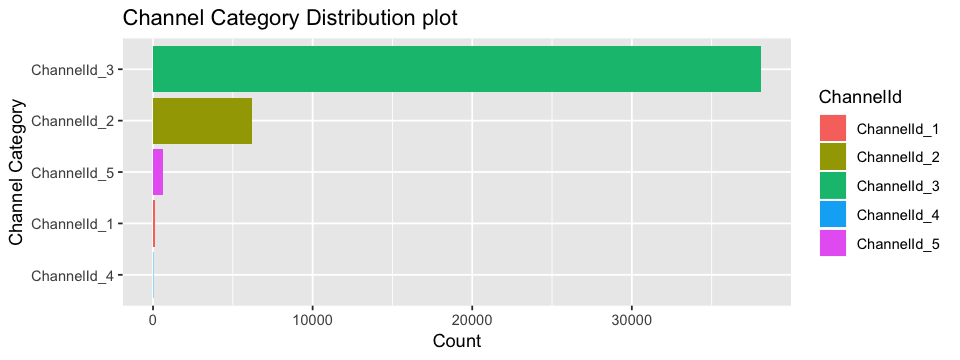

In [34]:
test %>% group_by(ChannelId) %>% count() %>% 

  ggplot() + geom_bar(aes(reorder(ChannelId,n),n,fill=ChannelId), stat = 'identity') + coord_flip() +
 xlab('Channel Category') + ylab('Count') +

  ggtitle('Channel Category Distribution plot')

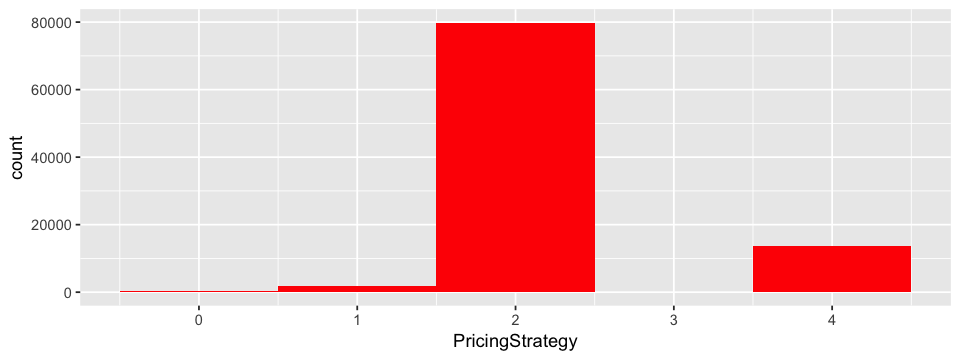

In [35]:
training %>%
ggplot(aes(x=PricingStrategy))+
  geom_histogram(bins = 5,fill= 'red')

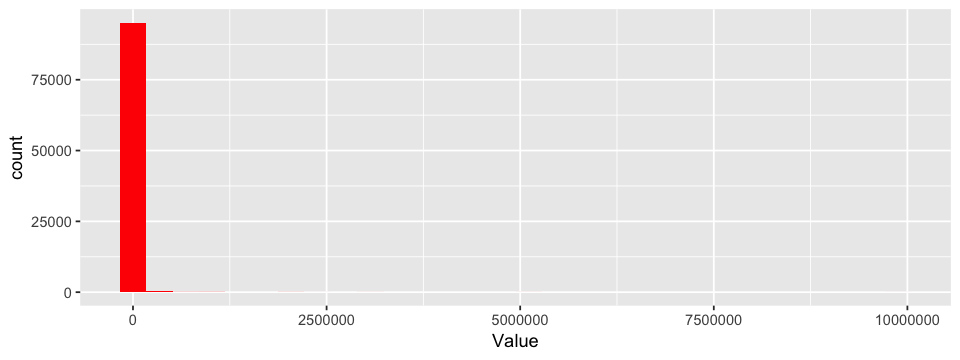

In [94]:
training %>%
ggplot(aes(x=Value))+
  geom_histogram(bins = 30,fill= 'red')

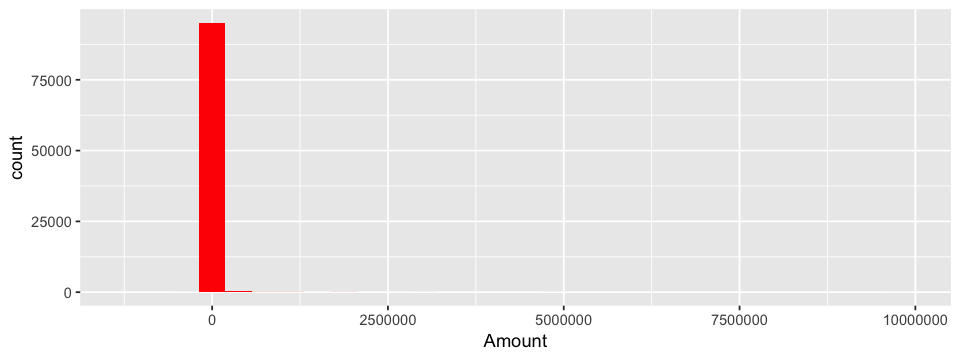

In [90]:
training %>%
ggplot(aes(x=Amount))+
  geom_histogram(bins = 30,fill= 'red')

##### Summary we don't need country code

### Relationships in the data

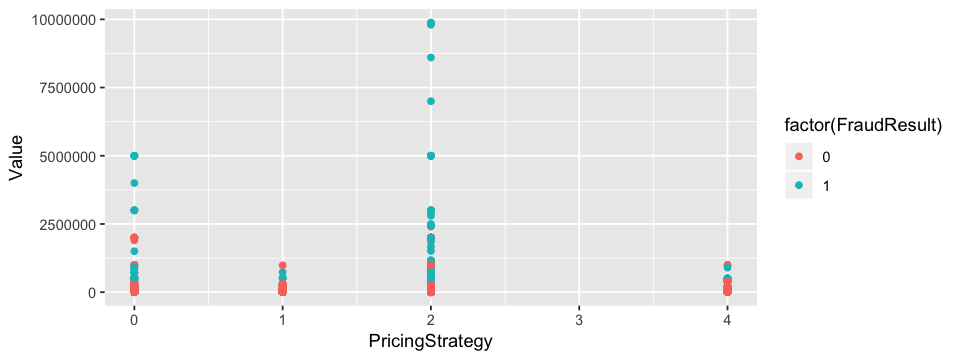

In [38]:
ggplot(training, aes(x = PricingStrategy, y = Value)) +
    geom_point(aes(color = factor(FraudResult)))

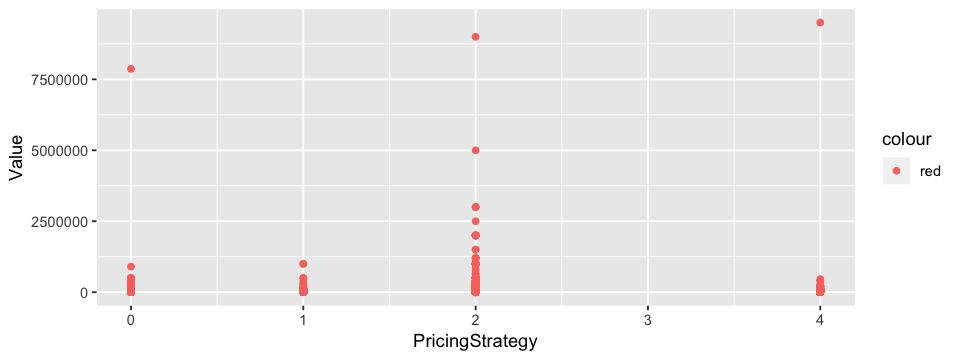

In [47]:
ggplot(test, aes(x = PricingStrategy, y = Value)) +
    geom_point(aes(colour="red"))

In [142]:
# value is interesting to look at (500k, 2.5m and above 2.5m)

# pricing strategy also looks like its a category

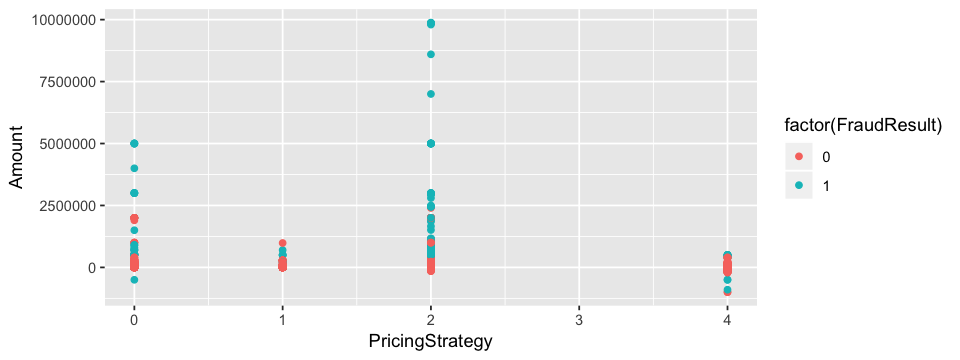

In [48]:
ggplot(training, aes(x = PricingStrategy, y = Amount)) +
    geom_point(aes(color = factor(FraudResult)))

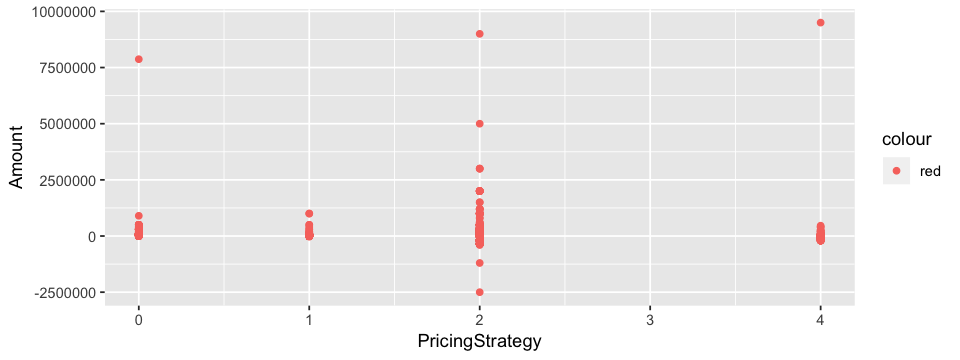

In [50]:
ggplot(test, aes(x = PricingStrategy, y = Amount)) +
    geom_point(aes(color = 'red'))

In [51]:
# we need to check the relationship between ammount and value


# they look to be correlated

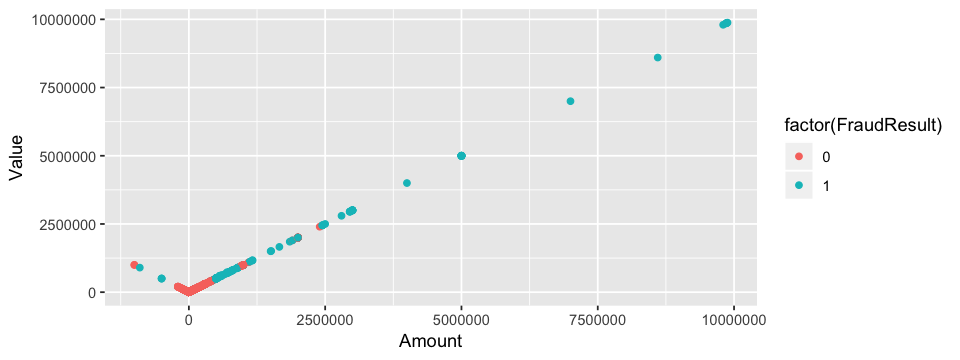

In [52]:
ggplot(training, aes(x = Amount, y = Value)) +
    geom_point(aes(color = factor(FraudResult)))

In [53]:
# There is no need even to check but for formality we shall still confirm the correlation



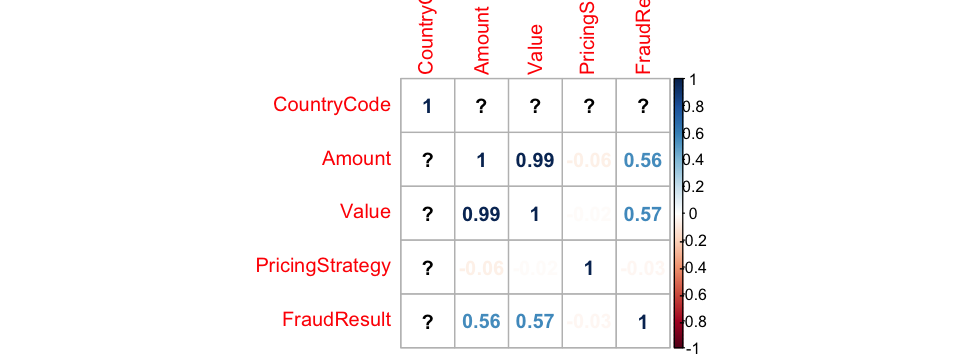

In [54]:
correlation <- cor(training[sapply(training, is.numeric)])
corrplot(correlation, method="number")

In [55]:
# Sure they are highly correlated as expected

# will prefer taking value to ammount

### In summary we have learnt that we dont need Currency code, country code and amount , also we have learnt that there is  pricing strategy is possibly a category than int. For future engineering we can see the value etc 

In [56]:
# Combining the train and test data set


new_data <- bind_rows(training,test)

In [57]:
tail(new_data)

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult
140676,TransactionId_135846,BatchId_19757,AccountId_4756,SubscriptionId_454,CustomerId_5225,UGX,256,ProviderId_3,ProductId_10,airtime,ChannelId_3,10000,10000,2019-03-14T23:56:06Z,1,NA
140677,TransactionId_116198,BatchId_117348,AccountId_4841,SubscriptionId_3829,CustomerId_5225,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_3,-5000,5000,2019-03-14T23:56:28Z,2,NA
140678,TransactionId_24829,BatchId_53630,AccountId_4803,SubscriptionId_1738,CustomerId_5272,UGX,256,ProviderId_3,ProductId_10,airtime,ChannelId_3,10000,10000,2019-03-14T23:57:38Z,1,NA
140679,TransactionId_102920,BatchId_112209,AccountId_4817,SubscriptionId_4613,CustomerId_5286,UGX,256,ProviderId_3,ProductId_10,airtime,ChannelId_3,10000,10000,2019-03-14T23:59:17Z,1,NA
140680,TransactionId_128439,BatchId_58734,AccountId_4841,SubscriptionId_3829,CustomerId_5286,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_3,-5000,5000,2019-03-14T23:59:39Z,2,NA
140681,TransactionId_45927,BatchId_98308,AccountId_4593,SubscriptionId_3866,CustomerId_5057,UGX,256,ProviderId_5,ProductId_3,airtime,ChannelId_3,3500,3500,2019-03-14T23:59:51Z,4,NA


In [58]:
new_data[is.na(new_data)] <- 2

In [59]:
tail(new_data)

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult
140676,TransactionId_135846,BatchId_19757,AccountId_4756,SubscriptionId_454,CustomerId_5225,UGX,256,ProviderId_3,ProductId_10,airtime,ChannelId_3,10000,10000,2019-03-14T23:56:06Z,1,2
140677,TransactionId_116198,BatchId_117348,AccountId_4841,SubscriptionId_3829,CustomerId_5225,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_3,-5000,5000,2019-03-14T23:56:28Z,2,2
140678,TransactionId_24829,BatchId_53630,AccountId_4803,SubscriptionId_1738,CustomerId_5272,UGX,256,ProviderId_3,ProductId_10,airtime,ChannelId_3,10000,10000,2019-03-14T23:57:38Z,1,2
140679,TransactionId_102920,BatchId_112209,AccountId_4817,SubscriptionId_4613,CustomerId_5286,UGX,256,ProviderId_3,ProductId_10,airtime,ChannelId_3,10000,10000,2019-03-14T23:59:17Z,1,2
140680,TransactionId_128439,BatchId_58734,AccountId_4841,SubscriptionId_3829,CustomerId_5286,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_3,-5000,5000,2019-03-14T23:59:39Z,2,2
140681,TransactionId_45927,BatchId_98308,AccountId_4593,SubscriptionId_3866,CustomerId_5057,UGX,256,ProviderId_5,ProductId_3,airtime,ChannelId_3,3500,3500,2019-03-14T23:59:51Z,4,2


In [60]:
# Drop the columns of the dataframe

new_data <- select(new_data,-c(CurrencyCode,Amount,CountryCode,SubscriptionId))

In [61]:
new_data$TransactionStartTime <- gsub(x=new_data$TransactionStartTime,pattern="T",
                              replacement=" ",fixed=T)
new_data$TransactionStartTime <- gsub(x=new_data$TransactionStartTime,pattern="Z",
                              replacement="",fixed=T)

In [62]:
tail(new_data)

,TransactionId,BatchId,AccountId,CustomerId,ProviderId,ProductId,ProductCategory,ChannelId,Value,TransactionStartTime,PricingStrategy,FraudResult
140676,TransactionId_135846,BatchId_19757,AccountId_4756,CustomerId_5225,ProviderId_3,ProductId_10,airtime,ChannelId_3,10000,2019-03-14 23:56:06,1,2
140677,TransactionId_116198,BatchId_117348,AccountId_4841,CustomerId_5225,ProviderId_4,ProductId_6,financial_services,ChannelId_3,5000,2019-03-14 23:56:28,2,2
140678,TransactionId_24829,BatchId_53630,AccountId_4803,CustomerId_5272,ProviderId_3,ProductId_10,airtime,ChannelId_3,10000,2019-03-14 23:57:38,1,2
140679,TransactionId_102920,BatchId_112209,AccountId_4817,CustomerId_5286,ProviderId_3,ProductId_10,airtime,ChannelId_3,10000,2019-03-14 23:59:17,1,2
140680,TransactionId_128439,BatchId_58734,AccountId_4841,CustomerId_5286,ProviderId_4,ProductId_6,financial_services,ChannelId_3,5000,2019-03-14 23:59:39,2,2
140681,TransactionId_45927,BatchId_98308,AccountId_4593,CustomerId_5057,ProviderId_5,ProductId_3,airtime,ChannelId_3,3500,2019-03-14 23:59:51,4,2


In [63]:
str(new_data)

'data.frame':	140681 obs. of  12 variables:
 $ TransactionId       : chr  "TransactionId_76871" "TransactionId_73770" "TransactionId_26203" "TransactionId_380" ...
 $ BatchId             : chr  "BatchId_36123" "BatchId_15642" "BatchId_53941" "BatchId_102363" ...
 $ AccountId           : chr  "AccountId_3957" "AccountId_4841" "AccountId_4229" "AccountId_648" ...
 $ CustomerId          : chr  "CustomerId_4406" "CustomerId_4406" "CustomerId_4683" "CustomerId_988" ...
 $ ProviderId          : chr  "ProviderId_6" "ProviderId_4" "ProviderId_6" "ProviderId_1" ...
 $ ProductId           : chr  "ProductId_10" "ProductId_6" "ProductId_1" "ProductId_21" ...
 $ ProductCategory     : chr  "airtime" "financial_services" "airtime" "utility_bill" ...
 $ ChannelId           : chr  "ChannelId_3" "ChannelId_2" "ChannelId_3" "ChannelId_3" ...
 $ Value               : int  1000 20 500 21800 644 2000 10000 500 500 600 ...
 $ TransactionStartTime: chr  "2018-11-15 02:18:49" "2018-11-15 02:19:08" "2018-11-15 

In [64]:
new_data$TransactionStartTime <- as.Date(new_data$TransactionStartTime)

In [65]:
str(new_data)

'data.frame':	140681 obs. of  12 variables:
 $ TransactionId       : chr  "TransactionId_76871" "TransactionId_73770" "TransactionId_26203" "TransactionId_380" ...
 $ BatchId             : chr  "BatchId_36123" "BatchId_15642" "BatchId_53941" "BatchId_102363" ...
 $ AccountId           : chr  "AccountId_3957" "AccountId_4841" "AccountId_4229" "AccountId_648" ...
 $ CustomerId          : chr  "CustomerId_4406" "CustomerId_4406" "CustomerId_4683" "CustomerId_988" ...
 $ ProviderId          : chr  "ProviderId_6" "ProviderId_4" "ProviderId_6" "ProviderId_1" ...
 $ ProductId           : chr  "ProductId_10" "ProductId_6" "ProductId_1" "ProductId_21" ...
 $ ProductCategory     : chr  "airtime" "financial_services" "airtime" "utility_bill" ...
 $ ChannelId           : chr  "ChannelId_3" "ChannelId_2" "ChannelId_3" "ChannelId_3" ...
 $ Value               : int  1000 20 500 21800 644 2000 10000 500 500 600 ...
 $ TransactionStartTime: Date, format: "2018-11-15" "2018-11-15" ...
 $ PricingStrateg

In [66]:
# Forgetting about date and time for now but there is a lot which can been with it 

# There is a very high can of it contributing to our prediction but we come back to it later

In [67]:
new_data <- select(new_data,-c(BatchId,AccountId,CustomerId))

# changing 

In [68]:
str(new_data)

'data.frame':	140681 obs. of  9 variables:
 $ TransactionId       : chr  "TransactionId_76871" "TransactionId_73770" "TransactionId_26203" "TransactionId_380" ...
 $ ProviderId          : chr  "ProviderId_6" "ProviderId_4" "ProviderId_6" "ProviderId_1" ...
 $ ProductId           : chr  "ProductId_10" "ProductId_6" "ProductId_1" "ProductId_21" ...
 $ ProductCategory     : chr  "airtime" "financial_services" "airtime" "utility_bill" ...
 $ ChannelId           : chr  "ChannelId_3" "ChannelId_2" "ChannelId_3" "ChannelId_3" ...
 $ Value               : int  1000 20 500 21800 644 2000 10000 500 500 600 ...
 $ TransactionStartTime: Date, format: "2018-11-15" "2018-11-15" ...
 $ PricingStrategy     : int  2 2 2 2 2 2 4 2 2 2 ...
 $ FraudResult         : num  0 0 0 0 0 0 0 0 0 0 ...


## MODELING 

In [69]:
# Before the modeling doing first label encoding

# Also assuming these are not that important
new_data <- select(new_data,-c(TransactionStartTime))

In [70]:
#Changing PricingStrategy to chr
new_data$PricingStrategy <- as.character(new_data$PricingStrategy)
# Saving names of categorical variables
to_be_encoded <- c('ProviderId','ProductId','ProductCategory','ChannelId','PricingStrategy')

# Label Encoder
for (i in to_be_encoded){
  encode <- LabelEncoder.fit(new_data[, i])
  new_data[, i] <- transform(encode, new_data[, i])
}

In [71]:
head(new_data)

TransactionId,ProviderId,ProductId,ProductCategory,ChannelId,Value,PricingStrategy,FraudResult
TransactionId_76871,6,2,1,3,1000,3,0
TransactionId_73770,4,24,3,2,20,3,0
TransactionId_26203,6,1,1,3,500,3,0
TransactionId_380,1,14,10,3,21800,3,0
TransactionId_28195,4,24,3,2,644,3,0
TransactionId_23223,6,21,1,3,2000,3,0


In [72]:
newdata2 <- dummy.data.frame(new_data, names=to_be_encoded, sep="_")

In [73]:
newdata3 <- newdata2
head(newdata3)

TransactionId,ProviderId_1,ProviderId_2,ProviderId_3,ProviderId_4,ProviderId_5,ProviderId_6,ProductId_1,ProductId_2,ProductId_3,ProductId_4,ProductId_5,ProductId_6,ProductId_7,ProductId_8,ProductId_9,ProductId_10,ProductId_11,ProductId_12,ProductId_13,ProductId_14,ProductId_15,ProductId_16,ProductId_17,ProductId_18,ProductId_19,ProductId_20,ProductId_21,ProductId_22,ProductId_23,ProductId_24,ProductId_25,ProductId_26,ProductId_27,ProductCategory_1,ProductCategory_2,ProductCategory_3,ProductCategory_4,ProductCategory_5,ProductCategory_6,ProductCategory_7,ProductCategory_8,ProductCategory_9,ProductCategory_10,ChannelId_1,ChannelId_2,ChannelId_3,ChannelId_4,ChannelId_5,Value,PricingStrategy_1,PricingStrategy_2,PricingStrategy_3,PricingStrategy_4,FraudResult
TransactionId_76871,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1000,0,0,1,0,0
TransactionId_73770,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,20,0,0,1,0,0
TransactionId_26203,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,500,0,0,1,0,0
TransactionId_380,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,21800,0,0,1,0,0
TransactionId_28195,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,644,0,0,1,0,0
TransactionId_23223,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2000,0,0,1,0,0


In [74]:
train_new <- newdata3 %>% filter(FraudResult < 2)
train_new <- select(train_new,-c(TransactionId))
tail(train_new)

,ProviderId_1,ProviderId_2,ProviderId_3,ProviderId_4,ProviderId_5,ProviderId_6,ProductId_1,ProductId_2,ProductId_3,ProductId_4,ProductId_5,ProductId_6,ProductId_7,ProductId_8,ProductId_9,ProductId_10,ProductId_11,ProductId_12,ProductId_13,ProductId_14,ProductId_15,ProductId_16,ProductId_17,ProductId_18,ProductId_19,ProductId_20,ProductId_21,ProductId_22,ProductId_23,ProductId_24,ProductId_25,ProductId_26,ProductId_27,ProductCategory_1,ProductCategory_2,ProductCategory_3,ProductCategory_4,ProductCategory_5,ProductCategory_6,ProductCategory_7,ProductCategory_8,ProductCategory_9,ProductCategory_10,ChannelId_1,ChannelId_2,ChannelId_3,ChannelId_4,ChannelId_5,Value,PricingStrategy_1,PricingStrategy_2,PricingStrategy_3,PricingStrategy_4,FraudResult
95657,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,50000,0,0,1,0,0
95658,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1000,0,0,1,0,0
95659,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1000,0,0,1,0,0
95660,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,20,0,0,1,0,0
95661,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,3000,0,0,1,0,0
95662,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,60,0,0,1,0,0


In [75]:
test_new <- newdata3 %>% filter(FraudResult == 2)
id <- test_new[ ,1]
test_new <- select(test_new,-c(TransactionId,FraudResult))
head(test_new)

ProviderId_1,ProviderId_2,ProviderId_3,ProviderId_4,ProviderId_5,ProviderId_6,ProductId_1,ProductId_2,ProductId_3,ProductId_4,ProductId_5,ProductId_6,ProductId_7,ProductId_8,ProductId_9,ProductId_10,ProductId_11,ProductId_12,ProductId_13,ProductId_14,ProductId_15,ProductId_16,ProductId_17,ProductId_18,ProductId_19,ProductId_20,ProductId_21,ProductId_22,ProductId_23,ProductId_24,ProductId_25,ProductId_26,ProductId_27,ProductCategory_1,ProductCategory_2,ProductCategory_3,ProductCategory_4,ProductCategory_5,ProductCategory_6,ProductCategory_7,ProductCategory_8,ProductCategory_9,ProductCategory_10,ChannelId_1,ChannelId_2,ChannelId_3,ChannelId_4,ChannelId_5,Value,PricingStrategy_1,PricingStrategy_2,PricingStrategy_3,PricingStrategy_4
0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1000,0,0,0,1
0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,2000,0,0,1,0
0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,50,0,0,1,0
0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,3000,0,0,0,1
0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,60,0,0,1,0
0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1000,0,0,1,0


In [76]:
head(id)

[1] "TransactionId_50600"  "TransactionId_95109"  "TransactionId_47357" 
[4] "TransactionId_28185"  "TransactionId_22140"  "TransactionId_134338"

In [77]:
# Modelling now

 set.seed(12345) # Random splitting of data, the set.seed is for same train and test set
Train <-createDataPartition(train_new$FraudResult, p =0.8, list = FALSE)

trainset <-train_new[Train,]
testset <-train_new[-Train,]


In [78]:
#testset <- testset%>%select(-c(FraudResult))

In [79]:
# checking dimensions
dim(trainset)
dim(testset)

[1] 76530    54

[1] 19132    54

In [80]:
trainset$FraudResult <- as.factor(trainset$FraudResult)
testset$FraudResult <- as.factor(testset$FraudResult)

In [81]:
# Feature importance with RF
fit_rf = randomForest(FraudResult~., data=trainset)

In [82]:
fit_rf


Call:
 randomForest(formula = FraudResult ~ ., data = trainset) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 7

        OOB estimate of  error rate: 0.08%
Confusion matrix:
      0   1  class.error
0 76357  24 0.0003142143
1    40 109 0.2684563758

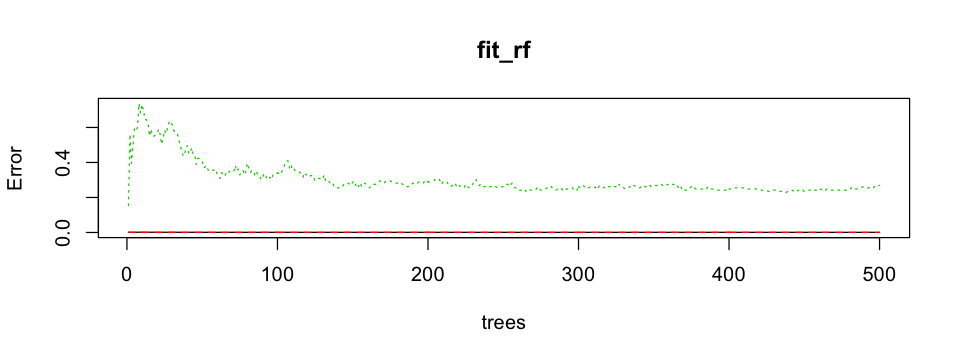

In [83]:
plot(fit_rf)

In [84]:
preds = predict(fit_rf, newdata = testset)


In [85]:
cm = confusion.matrix(preds, testset$FraudResult)
cm

    obs
pred     0  1
   0 19082  6
   1    10 34
attr(,"class")
[1] "confusion.matrix"

In [86]:
preds_test = predict(fit_rf, newdata = test_new)


In [87]:
submision <- data.frame(id, preds_test)
colnames(submision) <- c("id", "Class")
write.csv(submision, "baseline.csv",row.names=F) # row.names removing index

In [88]:
##### score 0.66666666.....